In [30]:
import polars as pl
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
import duckdb as db
from datetime import datetime

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tools.sm_exceptions import ConvergenceWarning
from sklearn.metrics import (
    mean_squared_error as mse,
    mean_absolute_error as mae,
    mean_absolute_percentage_error as mape
)
# onehot encoding
from sklearn.preprocessing import OneHotEncoder

sns.set_theme(style="whitegrid")

In [2]:
df=pd.read_parquet("../data/cleaned/df.parquet")
df.head()

,Temperature,Rainfall_last_hour,Cloud_Cover,Weather,TimeStamp,Traffic_Vol,data,Holiday,day,month,year,hour,minute,weekday_name,is_weekend
0,289.28,0,40,cloudy skies,2008-10-02 09:00:00,5555.0,Train,0,2,10,2008,9,0,Thursday,0
1,290.26,0,75,cloudy skies,2008-10-02 10:00:00,4525.0,Train,0,2,10,2008,10,0,Thursday,0
2,290.28,0,90,cloudy skies,2008-10-02 11:00:00,4772.0,Train,0,2,10,2008,11,0,Thursday,0
3,290.33,0,90,cloudy skies,2008-10-02 12:00:00,5031.0,Train,0,2,10,2008,12,0,Thursday,0
4,292.14,0,75,cloudy skies,2008-10-02 13:00:00,4928.0,Train,0,2,10,2008,13,0,Thursday,0


In [4]:
df = df.set_index("TimeStamp")

KeyError: "None of ['TimeStamp'] are in the columns"

In [5]:
df

,Temperature,Rainfall_last_hour,Cloud_Cover,Weather,Traffic_Vol,data,Holiday,day,month,year,hour,minute,weekday_name,is_weekend
TimeStamp,,,,,,,,,,,,,,
2008-10-02 09:00:00,289.28,0,40,cloudy skies,5555.0,Train,0,2,10,2008,9,0,Thursday,0
2008-10-02 10:00:00,290.26,0,75,cloudy skies,4525.0,Train,0,2,10,2008,10,0,Thursday,0
2008-10-02 11:00:00,290.28,0,90,cloudy skies,4772.0,Train,0,2,10,2008,11,0,Thursday,0
2008-10-02 12:00:00,290.33,0,90,cloudy skies,5031.0,Train,0,2,10,2008,12,0,Thursday,0
2008-10-02 13:00:00,292.14,0,75,cloudy skies,4928.0,Train,0,2,10,2008,13,0,Thursday,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2014-09-30 19:00:00,283.85,0,75,cloudy skies,NaN,Test,0,30,9,2014,19,0,Tuesday,0
2014-09-30 20:00:00,283.06,0,90,cloudy skies,NaN,Test,0,30,9,2014,20,0,Tuesday,0
2014-09-30 21:00:00,282.93,0,90,stormy weather,NaN,Test,0,30,9,2014,21,0,Tuesday,0


<Axes: xlabel='TimeStamp'>

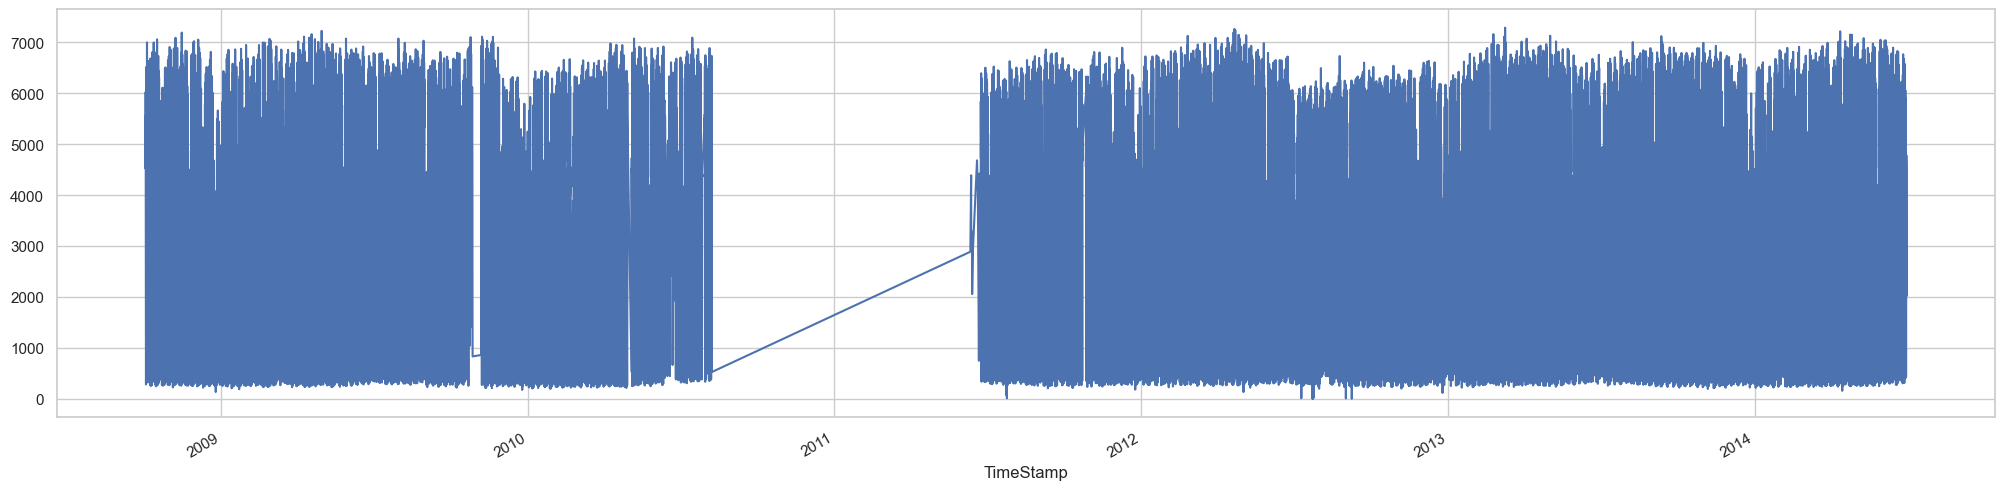

In [69]:
df["Traffic_Vol"].plot(figsize=(25, 6))

In [6]:
df["time_diff"] = df.index.diff()

In [7]:
df[df['time_diff'] > pd.Timedelta(days=50)] 

,Temperature,Rainfall_last_hour,Cloud_Cover,Weather,Traffic_Vol,data,Holiday,day,month,year,hour,minute,weekday_name,is_weekend,time_diff
TimeStamp,,,,,,,,,,,,,,,
2011-06-11 20:00:00,288.086,0,92,rainfall,2888.0,Train,0,11,6,2011,20,0,Saturday,1,307 days 19:00:00


In [71]:
df["2010-08-07 00:00:00":"2011-06-12 20:00:00"]

,Temperature,Rainfall_last_hour,Cloud_Cover,Weather,Traffic_Vol,data,Holiday,day,month,year,hour,minute,weekday_name,is_weekend,time_diff
TimeStamp,,,,,,,,,,,,,,,
2010-08-07 00:00:00,292.880,0,1,clear skies,727.0,Train,0,7,8,2010,0,0,Saturday,1,0 days 01:00:00
2010-08-07 01:00:00,291.710,0,2,light fog,472.0,Train,0,7,8,2010,1,0,Saturday,1,0 days 01:00:00
2010-08-07 02:00:00,291.380,0,1,clear skies,382.0,Train,0,7,8,2010,2,0,Saturday,1,0 days 01:00:00
2010-08-07 03:00:00,290.690,0,2,light fog,431.0,Train,0,7,8,2010,3,0,Saturday,1,0 days 01:00:00
2010-08-07 14:00:00,301.180,0,1,clear skies,5827.0,Train,0,7,8,2010,14,0,Saturday,1,0 days 11:00:00
2010-08-07 15:00:00,300.700,0,40,cloudy skies,6174.0,Train,0,7,8,2010,15,0,Saturday,1,0 days 01:00:00
2010-08-07 16:00:00,301.890,0,1,clear skies,6735.0,Train,0,7,8,2010,16,0,Saturday,1,0 days 01:00:00
2010-08-07 17:00:00,300.980,0,2,clear skies,6281.0,Train,0,7,8,2010,17,0,Saturday,1,0 days 01:00:00
2010-08-07 18:00:00,300.080,0,40,cloudy skies,5123.0,Train,0,7,8,2010,18,0,Saturday,1,0 days 01:00:00


In [8]:
df["cut_point"] = np.where(df.index < "2011-06-11 20:00:00", 0, 1)

<Axes: >

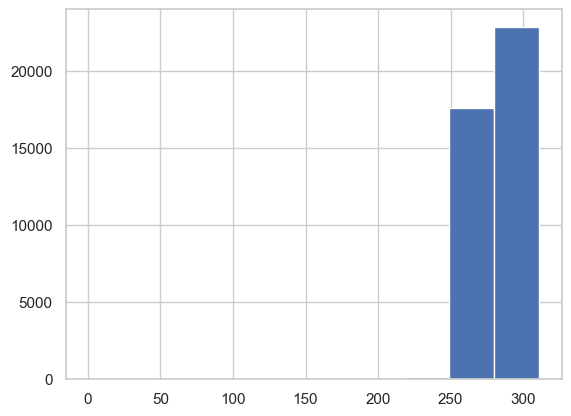

In [9]:
df["Temperature"].hist()

In [10]:
df["Temperature"]=np.clip(df["Temperature"], df["Temperature"].quantile(0.01), df["Temperature"].max())

<Axes: >

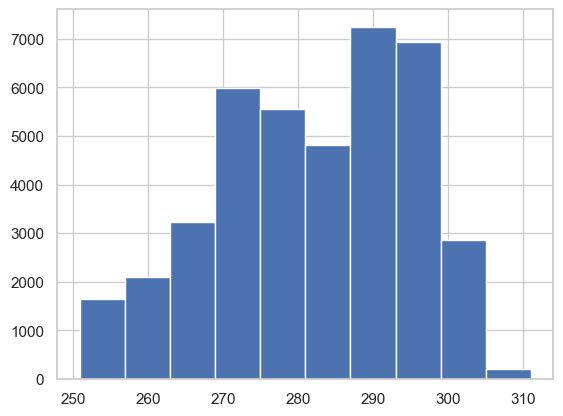

In [11]:
df["Temperature"].hist()

<Axes: >

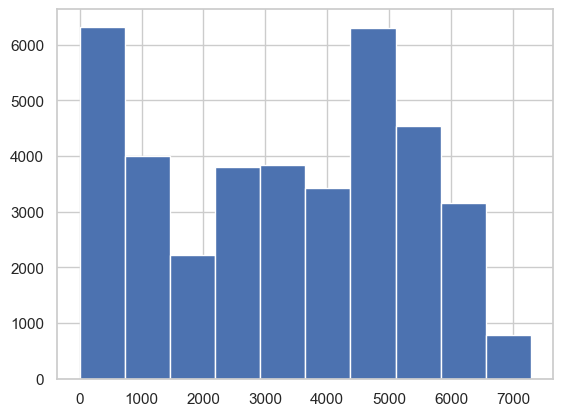

In [44]:
df["Traffic_Vol"].hist()

<Axes: xlabel='Temperature', ylabel='Traffic_Vol'>

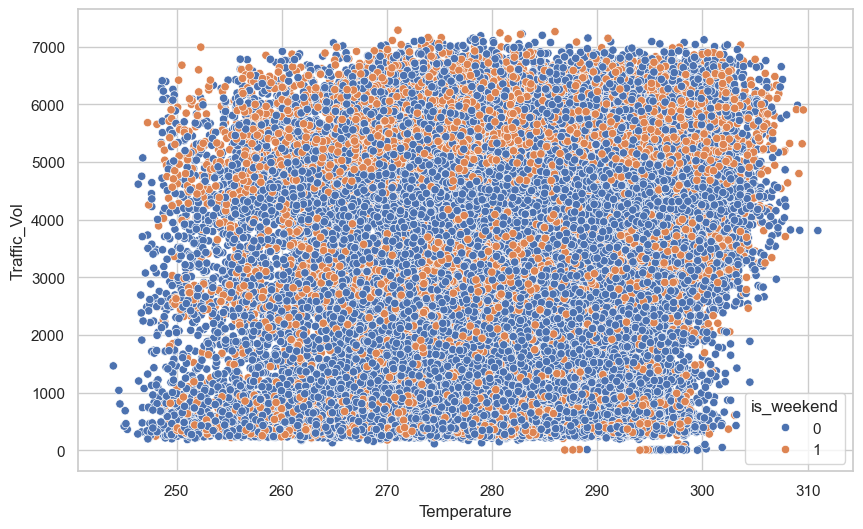

In [31]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df[(df["data"]=="Train") & (df["Temperature"]>10) ], x="Temperature", y="Traffic_Vol", hue="is_weekend")

In [13]:
df

,Temperature,Rainfall_last_hour,Cloud_Cover,Weather,Traffic_Vol,data,Holiday,day,month,year,hour,minute,weekday_name,is_weekend,time_diff,cut_point
TimeStamp,,,,,,,,,,,,,,,,
2008-10-02 09:00:00,289.28,0,40,cloudy skies,5555.0,Train,0,2,10,2008,9,0,Thursday,0,NaT,0
2008-10-02 10:00:00,290.26,0,75,cloudy skies,4525.0,Train,0,2,10,2008,10,0,Thursday,0,0 days 01:00:00,0
2008-10-02 11:00:00,290.28,0,90,cloudy skies,4772.0,Train,0,2,10,2008,11,0,Thursday,0,0 days 01:00:00,0
2008-10-02 12:00:00,290.33,0,90,cloudy skies,5031.0,Train,0,2,10,2008,12,0,Thursday,0,0 days 01:00:00,0
2008-10-02 13:00:00,292.14,0,75,cloudy skies,4928.0,Train,0,2,10,2008,13,0,Thursday,0,0 days 01:00:00,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2014-09-30 19:00:00,283.85,0,75,cloudy skies,NaN,Test,0,30,9,2014,19,0,Tuesday,0,0 days 01:00:00,1
2014-09-30 20:00:00,283.06,0,90,cloudy skies,NaN,Test,0,30,9,2014,20,0,Tuesday,0,0 days 01:00:00,1
2014-09-30 21:00:00,282.93,0,90,stormy weather,NaN,Test,0,30,9,2014,21,0,Tuesday,0,0 days 01:00:00,1


In [18]:
# adfuller test

def adfuller_test(series):
    result = adfuller(series)
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    print(f'Critical Values:' , result[4])
    print('Is the time series stationary?')
    if result[1] <= 0.05:
        print('Yes')
    else:
        print('No')
    
adfuller_test(time_series_df["Traffic_Vol"])

ADF Statistic: -21.210443094769214
p-value: 0.0
Critical Values: {'1%': -3.430617746964369, '5%': -2.861658335929215, '10%': -2.5668329867764026}
Is the time series stationary?
Yes


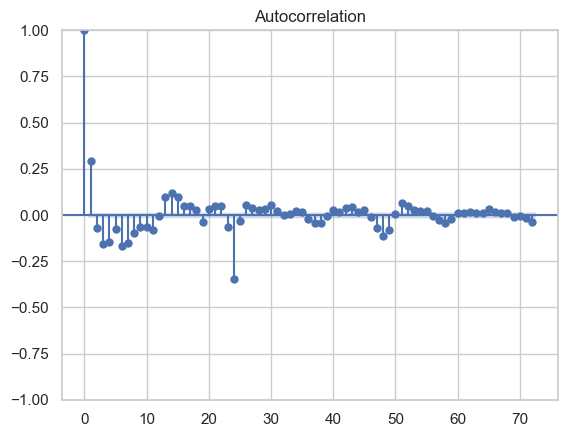

In [29]:
plot_acf(time_series_df["Traffic_Vol"].diff(1).diff(24).dropna(), lags=72);
# plot_pacf(time_series_df["Traffic_Vol"], lags=48);

In [41]:
onehot_encoded_df = pd.DataFrame(
    OneHotEncoder().fit_transform(df["Weather"].values.reshape(-1, 1)).toarray(),
    columns=OneHotEncoder().fit(df["Weather"].values.reshape(-1, 1)).get_feature_names_out()
)

In [43]:
onehot_encoded_df.index = df.index
df = pd.concat([df, onehot_encoded_df], axis=1)

In [45]:
df.head().T

TimeStamp,2008-10-02 09:00:00,2008-10-02 10:00:00,2008-10-02 11:00:00,2008-10-02 12:00:00,2008-10-02 13:00:00
Temperature,289.28,290.26,290.28,290.33,292.14
Rainfall_last_hour,0,0,0,0,0
Cloud_Cover,40,75,90,90,75
Weather,cloudy skies,cloudy skies,cloudy skies,cloudy skies,cloudy skies
Traffic_Vol,5555.0,4525.0,4772.0,5031.0,4928.0
data,Train,Train,Train,Train,Train
Holiday,0,0,0,0,0
day,2,2,2,2,2
month,10,10,10,10,10
year,2008,2008,2008,2008,2008


In [50]:
time_series_df = df[df["cut_point"]==1]
to_drop = ["cut_point", "time_diff", "Weather","weekday_name", "day", "month", "year","hour","minute"]
time_series_df = time_series_df.drop(columns=to_drop)

In [51]:
time_series_df

,Temperature,Rainfall_last_hour,Cloud_Cover,Traffic_Vol,data,Holiday,is_weekend,x0_airborne particles,x0_airborne smoke,x0_clear skies,x0_cloudy skies,x0_dense fog,x0_light fog,x0_light rain,x0_rainfall,x0_snowfall,x0_stormy weather,x0_sudden windstorm
TimeStamp,,,,,,,,,,,,,,,,,,
2011-06-11 20:00:00,288.086,0,92,2888.0,Train,0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2011-06-12 18:00:00,298.043,0,0,4389.0,Train,0,1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-06-12 20:00:00,292.961,0,8,3102.0,Train,0,1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-06-12 21:00:00,292.361,0,9,3300.0,Train,0,1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-06-13 21:00:00,295.340,0,76,3048.0,Train,0,0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2014-09-30 19:00:00,283.850,0,75,NaN,Test,0,0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2014-09-30 20:00:00,283.060,0,90,NaN,Test,0,0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2014-09-30 21:00:00,282.930,0,90,NaN,Test,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [52]:
time_series_df.to_parquet("../data/cleaned/df_time_series.parquet")

In [46]:
df.to_parquet("../data/cleaned/df_extended.parquet")